In [1]:
from bessel import bessel_roots, J_lx
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import numba as nb

## First step   
Compute the roots of the spherical bessel-functions $j_l(x)$, l $\in$ [0,...,100] and x $\in$ [0,...,100]

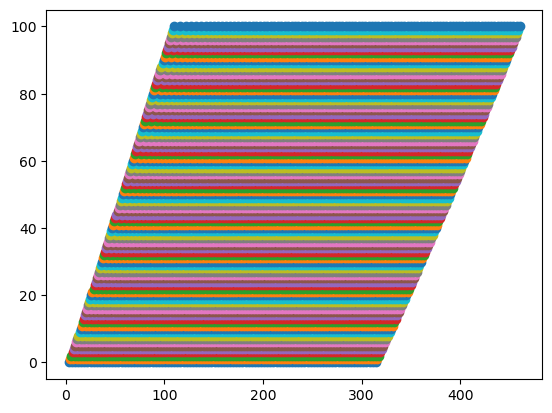

In [2]:
n_roots = 100
l_max = 100
roots = bessel_roots(l_max, n_roots,scipy = True)
for l in range(len(roots)):
    plt.plot(roots[l],l*np.ones(len(roots[l])),'o')

In [3]:
# R = 10 fm
R  = 10 * 1e-15
#now we want to calculate the wavenumbers. we know the relation between the wavenumber and the roots of the besse function
# j_l(k_il R) = 0.
k_il = roots / R

In [4]:
#now we want to check the orthogonality of the spherical bessel functions
#we want to calculate the integral of j_l(k_il R) * j_l(k_il R) * r^2 dr from 0 to R
#for this we use the trapezoidal rule
def trapz(func: callable, a, b, N: int ):
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    return (0.5 * func(a) + np.sum(func(r_i)) + 0.5 * func(b)) * dr

def trapz2(func: callable, a, b, N: int ):
    "trapzoidal rule with for loops"
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    integral = 0
    for i in range(N):
        integral += func(r_i[i])
    return (0.5 * func(a) + integral + 0.5 * func(b)) * dr
    
    
#now we test it with a known function
def f(x):
    return np.sin(x)
print(trapz(f,0,np.pi,200))
print(trapz2(f,0,np.pi,200))
#the known integral is 2

1.9999588764792147
1.9999588764792162


Now we want to check the orthonormality of the spherical bessel-functions. We use the following integral:
$$
\int_0^R j_l(k_{li} r) j_l(k_{lj} r) r^2 dr = \delta_{ij} \frac{1}{\alpha_{ij}^2}
$$
with $\alpha_{ij} = \frac{1}{j_{l-1}(k_{jl R})} \cdot \sqrt{2/R^3}$



In [5]:
@nb.jit(nopython=True)
def integrand(r,l,j):
    "define the integrand for the orthogonality of the spherical bessel functions"
    return J_lx(l,k_il[l,j] * r) * J_lx(l,k_il[l,j] * r) * r**2

def integrand2(r,l,j):
    "define the integrand for the orthogonality of the spherical bessel functions with scipy.special"
    return sp.spherical_jn(l,k_il[l,j] * r) * sp.spherical_jn(l,k_il[l,j] * r) * r**2

#now we want to calculate the integral for different l and j
#we want to store the results in a matrix

def create_integration_matrix(l_max,n_roots,scipy = False):
    "creates a matrix with the integrals of the spherical bessel functions defined above for every l and j"
    integral_ij = np.zeros((l_max,n_roots))
    if not scipy:
        for l in range(l_max):
            for j in range(n_roots):
                @np.vectorize
                def func2(r):
                    return integrand(r,l,j)
                integral_ij[l,j] = trapz(func2,0.1,R,1000)
        return integral_ij
    else:
        for l in range(l_max):
            for j in range(n_roots):
                def func2(r):
                    return integrand2(r,l,j)
                integral_ij[l,j] = trapz(func2,0,R,1000)
        return integral_ij


In [6]:
#now we want to calculate the alpha matrix
def calculate_alpha_matrix(l_max,n_roots, scipy = False):
    "calculates the alpha matrix for every l and j"
    alpha_ij = np.zeros((l_max,n_roots))
    for i in range(0,n_roots):
        alpha_ij[0,i] =  np.sqrt(2/R**3) * (i +1) * np.pi
    for l in range(1,l_max):
        for i in range(0,n_roots):
            if not scipy:
                alpha_ij[l,i] = 1 / J_lx(l-1,k_il[l,i] * R) * np.sqrt(2/R**3)
            else:
                alpha_ij[l,i] = 1/ sp.spherical_jn(l-1,k_il[l,i] * R) * np.sqrt(2/R**3)
    return alpha_ij


In [7]:
scipy_ = False
l_max, n_roots = 100, 100
integral_ij = create_integration_matrix(l_max,n_roots,scipy = scipy_)
alpha_ij = calculate_alpha_matrix(l_max,n_roots,scipy = scipy_)
alpha_ij_invsq = 1/alpha_ij**2
integral_diag = np.diag(integral_ij)
alpha_ij_invsq_diag = np.diag(alpha_ij_invsq)
print(" The wavenumbers are orthogonal: ", (np.isclose(integral_diag,alpha_ij_invsq_diag)))


 The wavenumbers are orthogonal:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


1.3) Now we want to diagonolize the matrix $A_{ij}$ = (i+j)/2 for N = 3,10,100 with the jacobi method.


In [39]:
N = 3
def A_entry(i,j):
    return (i+j)/2
index_list = np.arange(1,N+1)
A = A_entry(index_list[:,None],index_list[None,:])
print(A)

[[1.  1.5 2. ]
 [1.5 2.  2.5]
 [2.  2.5 3. ]]


In [48]:
import numpy as np

class Jacobi:
    def __init__(self, aa):
        self.n = aa.shape[0]
        self.a = aa
        self.v = np.identity(self.n)
        self.d = np.diag(aa).copy()
        self.nrot = 0
        self.EPS = np.finfo(float).eps

    def eigsrt(self):
        indices = np.argsort(self.d)[::-1]
        self.d = self.d[indices]
        self.v = self.v[:, indices]

    def jacobi(self):
        for ip in range(self.n):
            for iq in range(self.n):
                self.v[ip, iq] = 0.0
            self.v[ip, ip] = 1.0

        b = np.zeros(self.n)
        z = np.zeros(self.n)

        for ip in range(self.n):
            b[ip] = self.d[ip]
            z[ip] = 0.0

        for i in range(50):
            sm = 0.0
            for ip in range(self.n - 1):
                for iq in range(ip + 1, self.n):
                    sm += abs(self.a[ip, iq])

            if sm == 0.0:
                self.eigsrt()
                return

            if i < 4:
                tresh = 0.2 * sm / (self.n * self.n)
            else:
                tresh = 0.0

            for ip in range(self.n - 1):
                for iq in range(ip + 1, self.n):
                    g = 100.0 * abs(self.a[ip, iq])

                    if i > 4 and g <= self.EPS * abs(self.d[ip]) and g <= self.EPS * abs(self.d[iq]):
                        self.a[ip, iq] = 0.0
                    elif abs(self.a[ip, iq]) > tresh:
                        h = self.d[iq] - self.d[ip]

                        if g <= self.EPS * abs(h):
                            t = self.a[ip, iq] / h
                        else:
                            theta = 0.5 * h / self.a[ip, iq]
                            t = 1.0 / (abs(theta) + np.sqrt(1.0 + theta**2))

                            if theta < 0.0:
                                t = -t

                        c = 1.0 / np.sqrt(1 + t**2)
                        s = t * c
                        tau = s / (1.0 + c)
                        h = t * self.a[ip, iq]
                        z[ip] -= h
                        z[iq] += h
                        self.d[ip] -= h
                        self.d[iq] += h
                        self.a[ip, iq] = 0.0

                        for j in range(ip):
                            self.rot(self.a, s, tau, j, ip, j, iq)
                        for j in range(ip + 1, iq):
                            self.rot(self.a, s, tau, ip, j, j, iq)
                        for j in range(iq + 1, self.n):
                            self.rot(self.a, s, tau, ip, j, iq, j)

                        for j in range(self.n):
                            self.rot(self.v, s, tau, j, ip, j, iq)

                        self.nrot += 1

            for ip in range(self.n):
                b[ip] += z[ip]
                self.d[ip] = b[ip]
                z[ip] = 0.0

        raise ValueError("Too many iterations in routine jacobi")

    def rot(self, a, s, tau, i, j, k, l):
        g = a[i, j]
        h = a[k, l]
        a[i, j] = g - s * (h + g * tau)
        a[k, l] = h + s * (g - h * tau)


def jacobi(aa):
    jac = Jacobi(aa)
    jac.jacobi()
    return jac.d, jac.v
A = np.array([[8, 1, 6],
[3, 5, 7],
[4, 9, 2]])
jacobi(A)


(array([13,  5, -3]),
 array([[ 0.72619719, -0.57563867, -0.37586933],
        [ 0.3537629 ,  0.78167886, -0.51364382],
        [ 0.58948236,  0.24003808,  0.7712926 ]]))